# Random initialization one site solver

Created 26/07/2024

Objectives:
* Randomly initalize unitaries and solve to see how good a score can we get.
* Perform for a number of different sites and wavefunctions.
* Compare scores with non-randomized score.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [152]:
from collections import Counter

In [2]:
from time import perf_counter

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries
from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

# Load data

In [6]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [7]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [8]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [9]:
psi_dict = dict()

In [10]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [11]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [12]:
test_psi = psi_dict[0.5]

In [13]:
test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=[np_I,]*3
)

In [14]:
test.compute_svd_approximate_expectation()

(-7.12531953394994e-19+0j)

In [15]:
small_symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [16]:
big_symmetry_actions = [l*50 for l in small_symmetry_actions]

In [64]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [17]:
symmetry_actions_with_boundary_unitaries = [
    [
        SymmetryActionWithBoundaryUnitaries(p, s)
        for p in psi_dict.values()
    ]
    for s in big_symmetry_actions
]

In [38]:
for l in symmetry_actions_with_boundary_unitaries:
    for e in l:
        e.compute_svd_approximate_expectation()

# Initial attempt

In [18]:
random_seed_right_expectations = list()
random_seed_left_expectations = list()

In [19]:
N = 200

In [20]:
tic = perf_counter()
for _ in range(N):
    rand_opt = OneSiteSolver(test, 5, 5, True)
    rand_opt.optimize()
    
    random_seed_right_expectations.append(rand_opt.right_abs_expectations[-1][-1])
    random_seed_left_expectations.append(rand_opt.left_abs_expectations[-1][-1])

toc = perf_counter()
time_elapsed = toc - tic

In [21]:
time_elapsed

11.40142554200429

In [22]:
avg_time = time_elapsed/N

In [23]:
avg_time

0.05700712771002145

In [24]:
pd_random_seed_right_expectations = pd.Series(random_seed_right_expectations)
pd_random_seed_left_expectations = pd.Series(random_seed_left_expectations)

In [25]:
pd_random_seed_right_expectations.describe()

count    200.000000
mean       1.304038
std        0.043027
min        1.270962
25%        1.275343
50%        1.275345
75%        1.365146
max        1.365147
dtype: float64

In [26]:
pd_random_seed_left_expectations.describe()

count    200.000000
mean       1.309702
std        0.055488
min        1.195636
25%        1.275345
50%        1.279825
75%        1.365146
max        1.365147
dtype: float64

In [27]:
random_seed_right_expectations = list()
random_seed_left_expectations = list()

In [28]:
N = 200

In [29]:
tic = perf_counter()
for _ in range(N):
    rand_opt = OneSiteSolver(test, 10, 10, True)
    rand_opt.optimize()
    
    random_seed_right_expectations.append(rand_opt.right_abs_expectations[-1][-1])
    random_seed_left_expectations.append(rand_opt.left_abs_expectations[-1][-1])

toc = perf_counter()
time_elapsed = toc - tic

In [30]:
time_elapsed

25.99505999998655

In [31]:
avg_time = time_elapsed/N

In [32]:
avg_time

0.12997529999993276

In [33]:
pd_random_seed_right_expectations = pd.Series(random_seed_right_expectations)
pd_random_seed_left_expectations = pd.Series(random_seed_left_expectations)

In [34]:
pd_random_seed_right_expectations.describe()

count    200.000000
mean       1.206611
std        0.066800
min        1.046904
25%        1.187352
50%        1.191886
75%        1.270487
max        1.365147
dtype: float64

In [35]:
pd_random_seed_left_expectations.describe()

count    200.000000
mean       1.217053
std        0.065149
min        1.050215
25%        1.187703
50%        1.195630
75%        1.270964
max        1.365147
dtype: float64

# Baseline scores

In [71]:
n_baseline = 20

In [72]:
left_baseline_scores = np.zeros(n_baseline)
right_baseline_scores = np.zeros(n_baseline)

In [73]:
base_opts = [
    [OneSiteSolver(e, 0, 0, auto_pad=False) for e in l]
    for l in symmetry_actions_with_boundary_unitaries
]   

In [74]:
len(symmetry_actions_with_boundary_unitaries)

4

In [75]:
len(psi_dict)

21

In [76]:
right_baseline_scores = np.zeros((4, 21, n_baseline))
left_baseline_scores = np.zeros((4, 21, n_baseline))
overall_expectations = np.zeros((4, 21, n_baseline))

In [77]:
for i, l in enumerate(base_opts):
    for j, e in enumerate(l):
        for k in range(n_baseline):
            e.pad_right()
            e.pad_left()
            e.optimize()
            right_baseline_scores[i,j,k] = e.right_abs_expectations[-1][-1]
            left_baseline_scores[i,j,k] = e.left_abs_expectations[-1][-1]
            overall_expectations[i,j,k] = e.get_abs_expectation()

## Final scores

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/3050914577.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


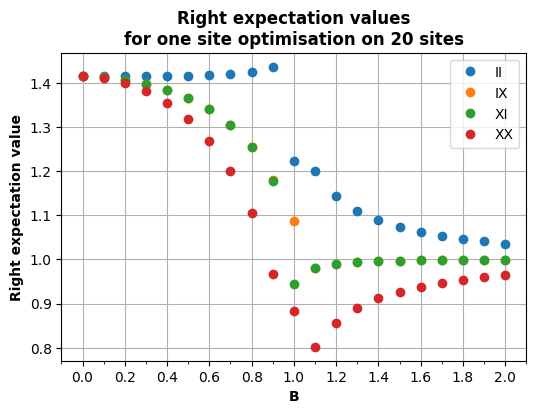

In [93]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(4):
    ax.plot(
        psi_dict.keys(),
        right_baseline_scores[i,:,-1],
        'o',
        label = symmetry_labels[i]
    )

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()
ax.grid()
ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Right expectation value", fontweight='bold')
ax.set_title(
    "Right expectation values\nfor one site optimisation on 20 sites",
    fontweight='bold'
)

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/1868750114.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


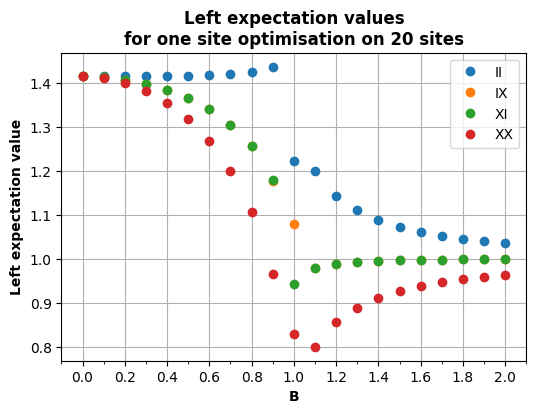

In [94]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(4):
    ax.plot(
        psi_dict.keys(),
        left_baseline_scores[i,:,-1],
        'o',
        label = symmetry_labels[i]
    )

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()
ax.grid()
ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Left expectation value", fontweight='bold')
ax.set_title(
    "Left expectation values\nfor one site optimisation on 20 sites",
    fontweight='bold'
)

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/1491506737.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


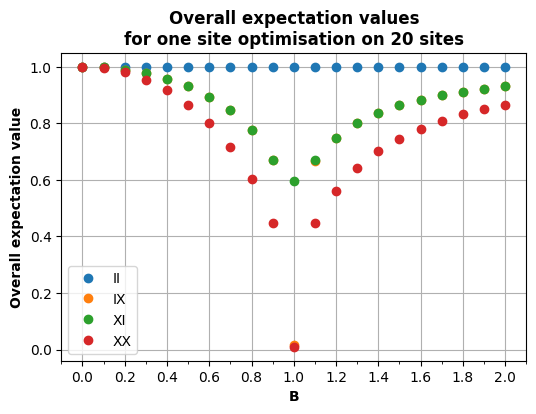

In [243]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(4):
    ax.plot(
        psi_dict.keys(),
        overall_expectations[i,:,-1],
        'o',
        label = symmetry_labels[i]
    )

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()
ax.grid()
ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Overall expectation value", fontweight='bold')
ax.set_title(
    "Overall expectation values\nfor one site optimisation on 20 sites",
    fontweight='bold'
)

fig.show()

## Score as a function of number of boundary unitaries

For $II$, all 1s (as expected.)

In [128]:
(np.min(overall_expectations[0,:,:]), np.max(overall_expectations[0,:,:]))

(0.9999999974506318, 1.0000000000000218)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/153390683.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


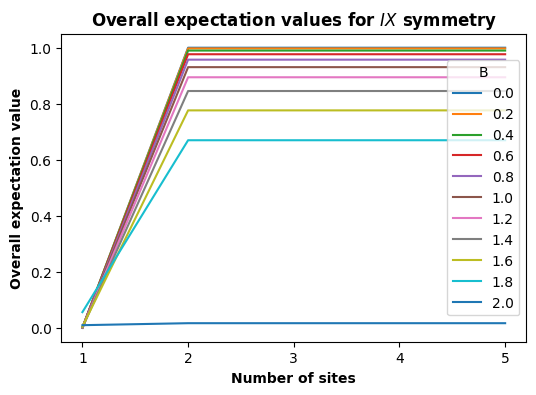

In [133]:
fig, ax = plt.subplots(figsize=(6,4))

for i, v in enumerate(list(psi_dict.keys())[::2]):
    ax.plot(
        list(range(1, 6)),
        overall_expectations[1,i,:5],
        label = v
    )

ax.legend(loc='right', title='B')
ax.set_xticks(list(range(1, 6)))
ax.set_xlabel("Number of sites", fontweight='bold')
ax.set_ylabel("Overall expectation value", fontweight='bold')
ax.set_title(
    "Overall expectation values for $IX$ symmetry",
    fontweight='bold'
)

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/1594301013.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


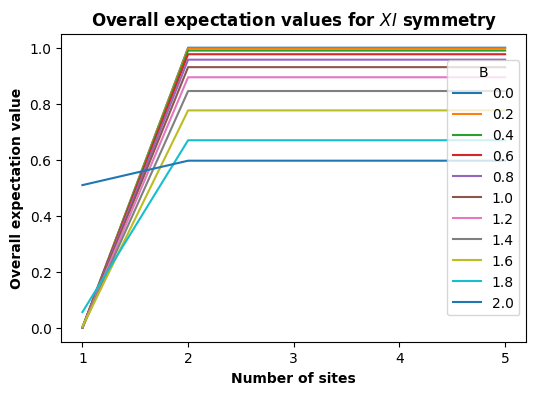

In [134]:
fig, ax = plt.subplots(figsize=(6,4))

for i, v in enumerate(list(psi_dict.keys())[::2]):
    ax.plot(
        list(range(1, 6)),
        overall_expectations[2,i,:5],
        label = v
    )

ax.legend(loc='right', title='B')
ax.set_xticks(list(range(1, 6)))
ax.set_xlabel("Number of sites", fontweight='bold')
ax.set_ylabel("Overall expectation value", fontweight='bold')
ax.set_title(
    "Overall expectation values for $XI$ symmetry",
    fontweight='bold'
)

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/3189876450.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


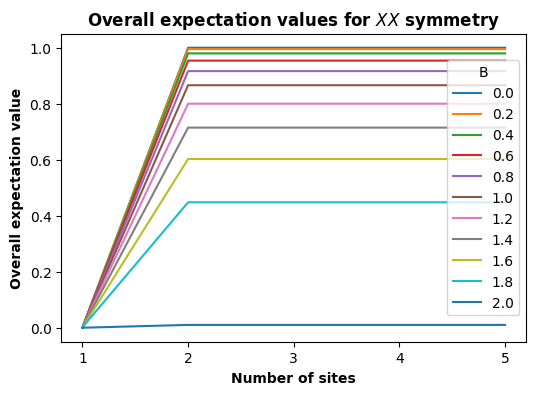

In [135]:
fig, ax = plt.subplots(figsize=(6,4))

for i, v in enumerate(list(psi_dict.keys())[::2]):
    ax.plot(
        list(range(1, 6)),
        overall_expectations[3,i,:5],
        label = v
    )

ax.legend(loc='right', title='B')
ax.set_xticks(list(range(1, 6)))
ax.set_xlabel("Number of sites", fontweight='bold')
ax.set_ylabel("Overall expectation value", fontweight='bold')
ax.set_title(
    "Overall expectation values for $XX$ symmetry",
    fontweight='bold'
)

fig.show()

In [146]:
np.max(overall_expectations[...,-1] - overall_expectations[...,1])

0.001155563619771871

So in general, the maximum value is attained on just two sites to a good approximation.

# Randomised scores

* How long? Get within 0.01 of optimal, then go for as many takes again.
* Do up until 5 unitaries for each symmetry and case.
* 

In [147]:
base_line_targets = np.max(overall_expectations, axis=-1)

In [148]:
base_line_targets.shape

(4, 21)

In [149]:
tolerance = 0.01

In [153]:
c = Counter()

In [154]:
c.update('hello')

In [209]:
def random_opimization(psi, n, symmetry_action, goal):
    scores = list()
    N = 0
    tolerance_met = False

    best_left_score = 0
    best_right_score = 0
    best_expectation = 0

    tic = perf_counter()

    def iteration():
        opt = OneSiteSolver(symmetry_action, n, n, True)
        opt.optimize()

        nonlocal best_right_score, best_left_score, best_expectation, scores

        best_right_score = max(best_right_score, opt.right_abs_expectations[-1][-1])
        best_left_score = max(best_left_score, opt.left_abs_expectations[-1][-1])
        best_expectation = max(
            best_expectation,
            (
                best_right_score
                *best_left_score
                *symmetry_action.symmetry_transfer_matrix_singular_vals[0]
            )
        )
        scores.append(best_expectation)

    while (not tolerance_met) and (N < 500):
        iteration()
        N+=1

        if best_expectation > goal - tolerance:
            tolerance_met = True

    for _ in range(N):
        iteration()

    toc = perf_counter()

    return (
        pd.Series(np.array(scores)).describe(),
        best_left_score,
        best_right_score,
        toc-tic
    )

In [210]:
quad = random_opimization(
    psi_dict[0],
    2,
    symmetry_actions_with_boundary_unitaries[0][0],
    base_line_targets[0,0]
)

In [211]:
quad

(count    2.0
 mean     1.0
 std      0.0
 min      1.0
 25%      1.0
 50%      1.0
 75%      1.0
 max      1.0
 dtype: float64,
 1.4142135623730954,
 1.4142135623730967,
 0.07349879198591225)

In [212]:
base_line_targets[0,0]

1.0000000000000004

In [213]:
num_sites_range = [2,4,6,8]

In [214]:
random_opt_out_data = list()

for i, l in enumerate(symmetry_actions_with_boundary_unitaries):
    print("Symmetry action: {}".format(i))
    random_opt_out_data.append(list())
    for j, (e, b) in enumerate(list(zip(l, psi_dict))[::2]):
        print("B: {}".format(b))
        random_opt_out_data[-1].append(list())
        for k, n in enumerate(num_sites_range):
            print("Number of sites: {}".format(n))
            quad = random_opimization(
                psi_dict[b],
                n,
                e,
                base_line_targets[i,j]
            )

            random_opt_out_data[-1][-1].append(quad)

            print("Time taken: {} s\n".format(quad[-1]))

Symmetry action: 0
B: 0.0
Number of sites: 2
Time taken: 0.03509495800244622 s

Number of sites: 4
Time taken: 0.035147457994753495 s

Number of sites: 6
Time taken: 0.06234162501641549 s

Number of sites: 8
Time taken: 0.08086108302813955 s

B: 0.2
Number of sites: 2
Time taken: 0.0705167920095846 s

Number of sites: 4
Time taken: 0.6222007500182372 s

Number of sites: 6
Time taken: 1.019590582989622 s

Number of sites: 8
Time taken: 7.568872000003466 s

B: 0.4
Number of sites: 2
Time taken: 0.028975166991585866 s

Number of sites: 4
Time taken: 0.5766944579954725 s

Number of sites: 6
Time taken: 2.878235375013901 s

Number of sites: 8
Time taken: 2.154187042004196 s

B: 0.6
Number of sites: 2
Time taken: 0.026386957993963733 s

Number of sites: 4
Time taken: 1.5275963330059312 s

Number of sites: 6
Time taken: 2.5722906249866355 s

Number of sites: 8
Time taken: 5.11199766700156 s

B: 0.8
Number of sites: 2
Time taken: 0.021544332994380966 s

Number of sites: 4
Time taken: 0.6549832

In [217]:
q = random_opt_out_data[0][0][0]

In [218]:
q[0]

count    2.000000e+00
mean     1.000000e+00
std      4.710277e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [219]:
q[1]

1.4142135623730956

In [220]:
q[2]

1.414213562373096

In [221]:
q[3]

0.03509495800244622

In [222]:
q[0]['max']

0.9999999999999999

In [223]:
rand_max_scores = np.zeros((4, 11, 4))
rand_max_left_scores = np.zeros((4, 11, 4))
rand_max_right_scores = np.zeros((4, 11, 4))

for i, l1 in enumerate(random_opt_out_data):
    for j, l2 in enumerate(l1):
        for k, l3 in enumerate(l2):
            rand_max_scores[i,j,k] = l3[0]['max']
            rand_max_left_scores[i,j,k] = l3[1]
            rand_max_right_scores[i,j,k] = l3[2]

In [224]:
rand_max_scores

array([[[1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99999993, 0.99999999],
        [1.        , 0.9999998 , 0.99999993, 0.999995  ],
        [1.        , 0.9999999 , 0.99999873, 0.99999696],
        [1.        , 0.99999937, 0.99999695, 0.99999419],
        [0.9999997 , 0.99999724, 0.99998866, 0.99999373],
        [1.        , 0.99999925, 0.99998632, 0.99996265],
        [1.        , 0.99999583, 0.99997676, 0.99990475],
        [1.        , 0.99999545, 0.99995042, 0.99983071],
        [1.        , 0.99999005, 0.99993105, 0.99966336],
        [1.        , 0.99999188, 0.99993038, 0.99980309]],

       [[1.        , 1.        , 1.        , 1.        ],
        [0.98984641, 0.9898464 , 0.9898464 , 0.9898464 ],
        [0.95734953, 0.95734953, 0.95734953, 0.95734953],
        [0.89449221, 0.8944922 , 0.89449218, 0.89449216],
        [0.77622954, 0.7762304 , 0.77623171, 0.77623369],
        [0.01617029, 0.01617028, 0.01617027, 0.01617027],
        [0.7

In [229]:
base_line_targets[:,::2].shape

(4, 11)

In [227]:
rand_max_scores.shape

(4, 11, 4)

Can assume that 8 sites gives close to the best score.

In [245]:
np.max(np.abs(np.max(rand_max_scores, axis=-1) - rand_max_scores[...,-1]))

0.00033663533239303156

In [231]:
rand_max_scores_diff = base_line_targets[:,::2, np.newaxis] - rand_max_scores

In [232]:
rand_max_scores_diff

array([[[ 5.55111512e-16, -4.44089210e-16,  4.44089210e-16,
          5.55111512e-16],
        [ 2.22044605e-16,  5.10107290e-10,  7.10512575e-08,
          1.19664847e-08],
        [ 7.32747196e-15,  1.96290047e-07,  7.39731519e-08,
          4.99751078e-06],
        [ 3.10862447e-15,  1.02787017e-07,  1.26570825e-06,
          3.03758080e-06],
        [ 1.02140518e-14,  6.34550075e-07,  3.04617752e-06,
          5.81247596e-06],
        [ 2.97122328e-07,  2.75619672e-06,  1.13355559e-05,
          6.26869422e-06],
        [ 6.66133815e-16,  7.45580620e-07,  1.36774429e-05,
          3.73494196e-05],
        [ 6.66133815e-16,  4.16923422e-06,  2.32406421e-05,
          9.52514596e-05],
        [ 2.66453526e-15,  4.55432915e-06,  4.95836531e-05,
          1.69290674e-04],
        [ 2.22044605e-15,  9.95179792e-06,  6.89471370e-05,
          3.36635332e-04],
        [ 5.55111512e-16,  8.11990389e-06,  6.96168373e-05,
          1.96906954e-04]],

       [[ 9.99200722e-16, -1.11022302e-16

In [233]:
np.max(np.abs(rand_max_scores_diff))

0.09489654175893758

In [234]:
base_line_targets[3, 12]

0.5610880159427649

In [236]:
rand_max_scores[3, 6]

array([0.61362281, 0.62594243, 0.64451579, 0.65598456])

In [241]:
base_line_targets[3, 20]

0.8660568680742208

In [242]:
rand_max_scores[3, 10]

array([0.86605687, 0.90111668, 0.91446782, 0.92229593])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/3920445253.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


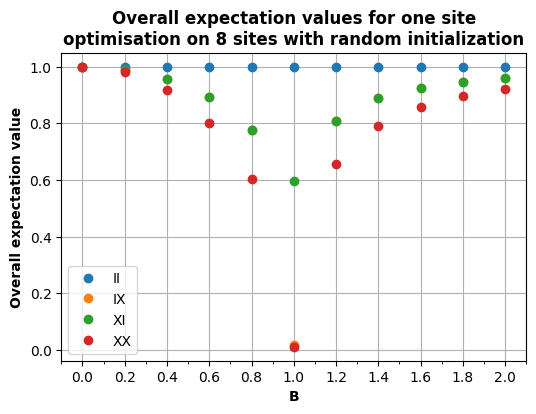

In [248]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(4):
    ax.plot(
        list(psi_dict.keys())[::2],
        rand_max_scores[i,:,-1],
        'o',
        label = symmetry_labels[i]
    )

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()
ax.grid()
ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Overall expectation value", fontweight='bold')
ax.set_title(
    "Overall expectation values for one site\noptimisation on 8 sites with random initialization",
    fontweight='bold'
)

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_34233/2219880948.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


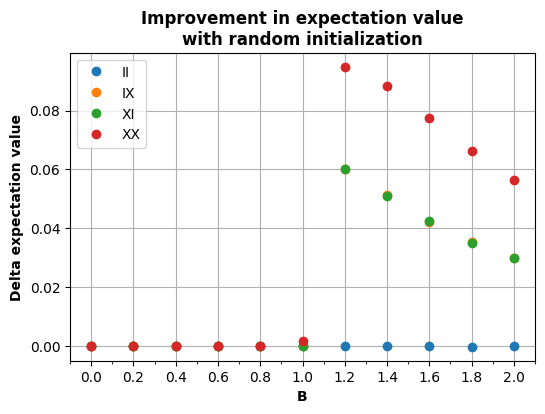

In [250]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(4):
    ax.plot(
        list(psi_dict.keys())[::2],
        -rand_max_scores_diff[i,:,-1],
        'o',
        label = symmetry_labels[i]
    )

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()
ax.grid()
ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Delta expectation value", fontweight='bold')
ax.set_title(
    "Improvement in expectation value\nwith random initialization",
    fontweight='bold'
)

fig.show()

# Conclusions
* Random initialisation does improve scores for $B>1$.